In [1]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
from pathlib import Path
sys.path.append('../src')
yt.enable_plugins()

yt : [INFO     ] 2025-05-12 14:46:04,951 Loading plugins from /home/dschneidinger/.config/yt/my_plugins.py


In [2]:
from datetime import datetime

datetime.today().strftime('%Y-%m-%d %H:%M:%S')

'2025-05-12 14:46:04'

In [3]:
# make plot text bigger

import matplotlib.pylab as pylab
import yt.config
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [4]:
# plot_path = "/home/dschneidinger/cellar/DEREK2/MagShockZ_hdf5_chk_0005"
# plot_path = "/home/dschneidinger/cellar/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"
# plot_path = "/home/dschneidinger/cellar/VAC_DEREK3D_20um/MagShockZ_hdf5_chk_0006"
plot_path = "/home/dschneidinger/shared/data/VAC_DEREK3D_20um/MagShockZ_hdf5_chk_0006"

ds = yt.load_for_osiris(plot_path,rqm = 100, B_background=75000)
# ds = yt.load(plot_path)

yt : [INFO     ] 2025-05-12 14:46:05,846 Particle file found: MagShockZ_hdf5_chk_0006


yt : [INFO     ] 2025-05-12 14:46:05,870 Parameters: current_time              = 4.157630190965378e-09
yt : [INFO     ] 2025-05-12 14:46:05,870 Parameters: domain_dimensions         = [384 496 384]
yt : [INFO     ] 2025-05-12 14:46:05,870 Parameters: domain_left_edge          = [-0.8   -0.075 -0.8  ]
yt : [INFO     ] 2025-05-12 14:46:05,871 Parameters: domain_right_edge         = [0.8 2.  0.8]
yt : [INFO     ] 2025-05-12 14:46:05,871 Parameters: cosmological_simulation   = 0


Hi mom!


In [5]:
ds.domain_dimensions

array([384, 496, 384], dtype=int32)

In [6]:
mins = ds.domain_left_edge
maxs = ds.domain_right_edge
print(mins)
print(maxs)

[-0.8   -0.075 -0.8  ] code_length
[0.8 2.  0.8] code_length


yt : [WARNING  ] 2025-05-12 16:39:57,938 Field ('flash', 'zbar') already exists. To override use `force_override=True`.
yt : [WARNING  ] 2025-05-12 16:40:01,540 Field ('flash', 'zbar_mask_14') was added without specifying units or dimensions, auto setting units to 'dimensionless'


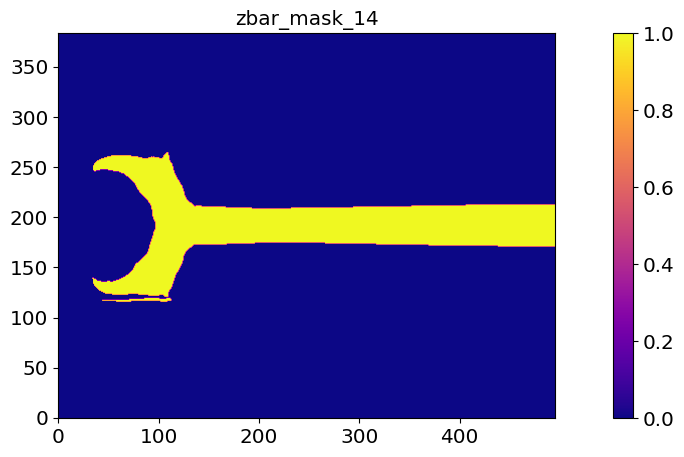

yt : [WARNING  ] 2025-05-12 16:40:01,795 Field ('flash', 'zbar_mask_13') was added without specifying units or dimensions, auto setting units to 'dimensionless'


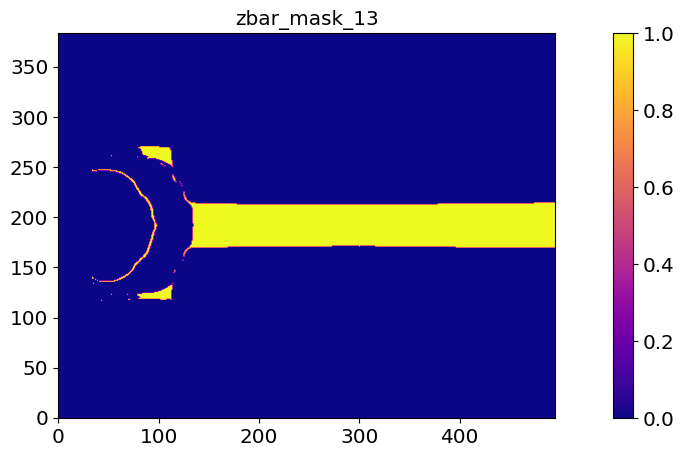

yt : [WARNING  ] 2025-05-12 16:40:02,053 Field ('flash', 'zbar_mask_6') was added without specifying units or dimensions, auto setting units to 'dimensionless'


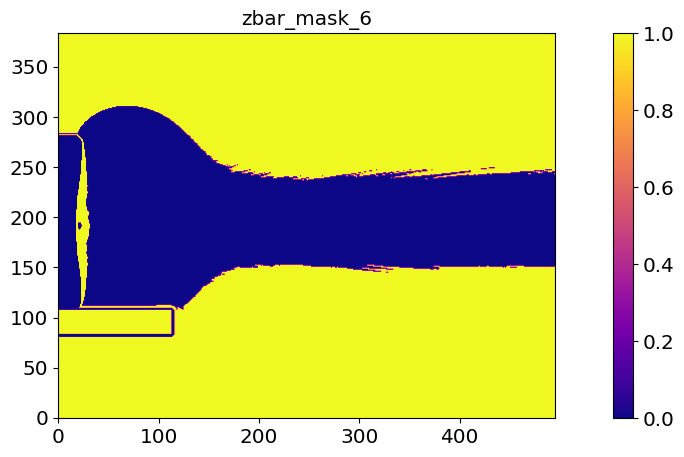

In [ ]:

# density and electron temp at y=0
z_middle_index = dims[2] // 2
# dens = pd.DataFrame(all_data['flash', 'dens'][:, :, z_middle_index])
# tele = pd.DataFrame(all_data['flash', 'tele'][:, :, z_middle_index])

# Define a new derived field that is ye times abar
def _ye_times_abar(field, data):
    return data["flash", "ye"] / data["flash", "sumy"]

ds.add_field(("flash", "zbar"), function=_ye_times_abar, sampling_type="cell")

# Apply a mask over zbar
def _zbar_mask_6(field, data):
    return np.where(np.isclose(data["flash", "zbar"], 6, atol=2), 1, 0)

def _zbar_mask_13(field, data):
    return np.where(np.isclose(data["flash", "zbar"], 13, atol=.05), 1, 0)
def _zbar_mask_14(field, data):
    return np.where(np.isclose(data["flash", "zbar"], 14, atol=.9), 1, 0)

ds.add_field(("flash", "zbar_mask_6"), function=_zbar_mask_6, sampling_type="cell",force_override=True)
ds.add_field(("flash", "zbar_mask_13"), function=_zbar_mask_13, sampling_type="cell",force_override=True)
ds.add_field(("flash", "zbar_mask_14"), function=_zbar_mask_14, sampling_type="cell",force_override=True)
target_index = 0
# slc = yt.SlicePlot(ds=ds, fields=['zbar'], normal = 'z',origin='native')
# slc.set_log('zbar', False)

# slc = yt.SlicePlot(ds=ds, fields=['zbar_mask_6'], normal = 'z')
# slc = yt.SlicePlot(ds=ds, fields=['zbar_mask_13'], normal = 'z',origin='native')

# create covering grid from ds
level = 0
dims = ds.domain_dimensions * ds.refine_by**level

# We construct an object that describes the data region and structure we want
# In this case, we want all data up to the maximum "level" of refinement
# across the entire simulation volume.  Higher levels than this will not
# contribute to our covering grid.

all_data = ds.covering_grid(
    level,
    left_edge=ds.domain_left_edge,
    dims=dims,
    # And any fields to preload (this is optional!)
)


plt.imshow(all_data['flash', 'zbar_mask_14'][:, :, z_middle_index], origin='lower', cmap='plasma')
plt.colorbar()
plt.title("zbar_mask_14")
plt.show()
plt.imshow(all_data['flash', 'zbar_mask_13'][:, :, z_middle_index], origin='lower', cmap='plasma')
plt.colorbar()
plt.title("zbar_mask_13")
plt.show()
plt.imshow(all_data['flash', 'zbar_mask_6'][:, :, z_middle_index], origin='lower', cmap='plasma')
plt.colorbar()
plt.title("zbar_mask_6")
plt.show()

In [8]:
plt.figure(figsize=(10,10))
im = plt.imshow(dens.T, norm=colors.LogNorm(), 
           cmap='plasma', origin='lower', extent=extents)
cbar = plt.colorbar(im, fraction=0.1, pad=0.04) # fraction and pad are for sizing the colorbar
cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')
plt.xlabel('r (cm)')
plt.ylabel('z (cm)')
plt.minorticks_on()
plt.xlim(0, extents[1])
plt.ylim(ylimmin, ylimmax)
plt.title("Mass density at t={} ns".format(time_pretty));
# plt.savefig("slice_mpl_{0}ns_{1}.png".format(time_pretty, datetime.today().strftime('%Y-%m-%d %H:%M:%S')), bbox_inches="tight")

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_278551/2696657589.py:5: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')
/tmp/ipykernel_278551/2696657589.py:5: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')


NameError: name 'dens' is not defined

<Figure size 1000x1000 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(tele.T, norm=colors.LogNorm(), 
           cmap='plasma', origin='lower', extent=extents)
cbar = plt.colorbar(im, fraction=0.1, pad=0.04)
cbar.set_label('temperature (K)')
plt.xlabel('r (cm)')
plt.ylabel('z (cm)')
plt.xlim(0, extents[1])
plt.ylim(ylimmin, ylimmax)
plt.title("Electron temp at t={} ns".format(time_pretty));
# plt.savefig("slice_mpl_{0}ns_{1}.png".format(time_pretty, datetime.today().strftime('%Y-%m-%d %H:%M:%S')), bbox_inches="tight")

yt : [INFO     ] 2025-01-17 18:53:38,162 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-01-17 18:53:38,163 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-01-17 18:53:38,164 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-01-17 18:53:38,164 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-01-17 18:53:38,165 Making a fixed resolution buffer of (('flash', 'edens')) 800 by 800
yt : [INFO     ] 2025-01-17 18:53:38,497 Saving plot ../results/FLASH_plots/edens_slice.png



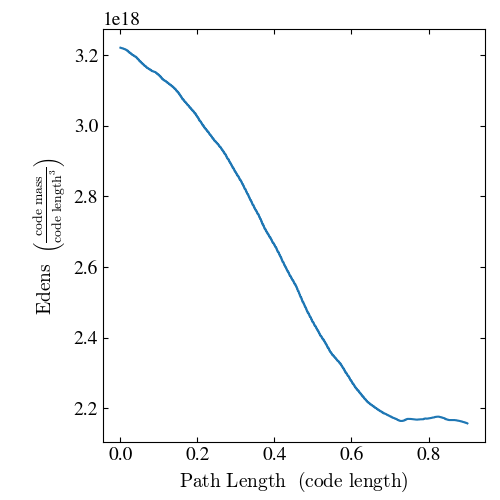

yt : [INFO     ] 2025-01-17 18:53:39,111 Saving plot ../results/FLASH_plots/edens_line.png


['../results/FLASH_plots/edens_line.png']

In [10]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","edens")).set_cmap("edens","rainbow")
slc.set_font_size(30)
slc.set_colorbar_label("edens", r"Electron Density (cm$^{-3}$)")
slc.save("../results/FLASH_plots/edens_slice.png")
line = yt.LinePlot(ds,"edens",start_point=(0,1,0),end_point=(0,1.9,0),npoints=1000)
line.set_log("edens",False)
line.show()
line.save("../results/FLASH_plots/edens_line.png")
# slc.show()

yt : [INFO     ] 2025-01-17 17:21:47,129 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-01-17 17:21:47,130 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-01-17 17:21:47,131 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-01-17 17:21:47,131 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-01-17 17:21:47,132 Making a fixed resolution buffer of (('flash', 'tele')) 800 by 800



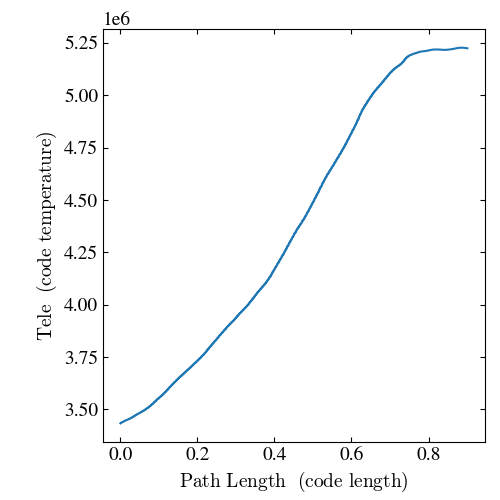

In [ ]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","tele")).set_cmap("tele","rainbow")
slc.set_font_size(30)
slc.set_colorbar_label("tele", r"Electron Density (cm$^{-3}$)")
# slc.save("../results/FLASH_plots/edens_slice.png")
line = yt.LinePlot(ds,"tele",start_point=(0,1,0),end_point=(0,1.9,0),npoints=1000)
line.set_log("tele",False)
line.show()
# line.save("../results/FLASH_plots/tele_slice.png")
# slc.show()


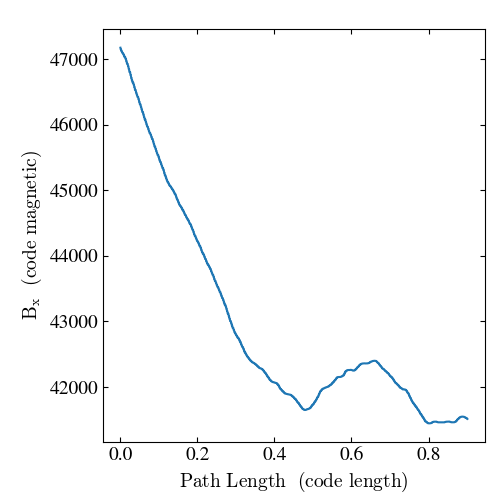

['../results/FLASH_plots/magx_line.png']

In [27]:
line = yt.LinePlot(ds,"magx",start_point=(0,1,0),end_point=(0,1.9,0),npoints=1000)
line.set_log("magx",False)
line.show()
line.save("../results/FLASH_plots/magx_line.png")


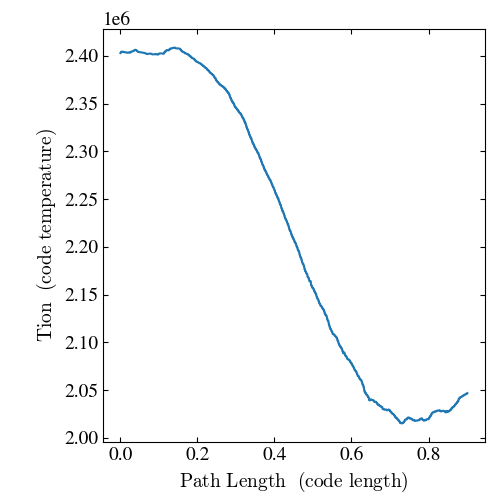

yt : [INFO     ] 2025-01-17 18:54:06,956 Saving plot ../results/FLASH_plots/tion_line.png


['../results/FLASH_plots/tion_line.png']

In [11]:
line = yt.LinePlot(ds,"tion",start_point=(0,1,0),end_point=(0,1.9,0),npoints=1000)
line.set_log("tion",False)
line.show()
line.save("../results/FLASH_plots/tion_line.png")

yt : [INFO     ] 2025-03-19 13:16:13,458 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-03-19 13:16:13,458 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-03-19 13:16:13,460 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-03-19 13:16:13,461 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-03-19 13:16:13,462 Making a fixed resolution buffer of (('flash', 'dens')) 800 by 800
yt : [INFO     ] 2025-03-19 13:16:14,864 Saving plot ../results/FLASH_plots/dens_slice.png



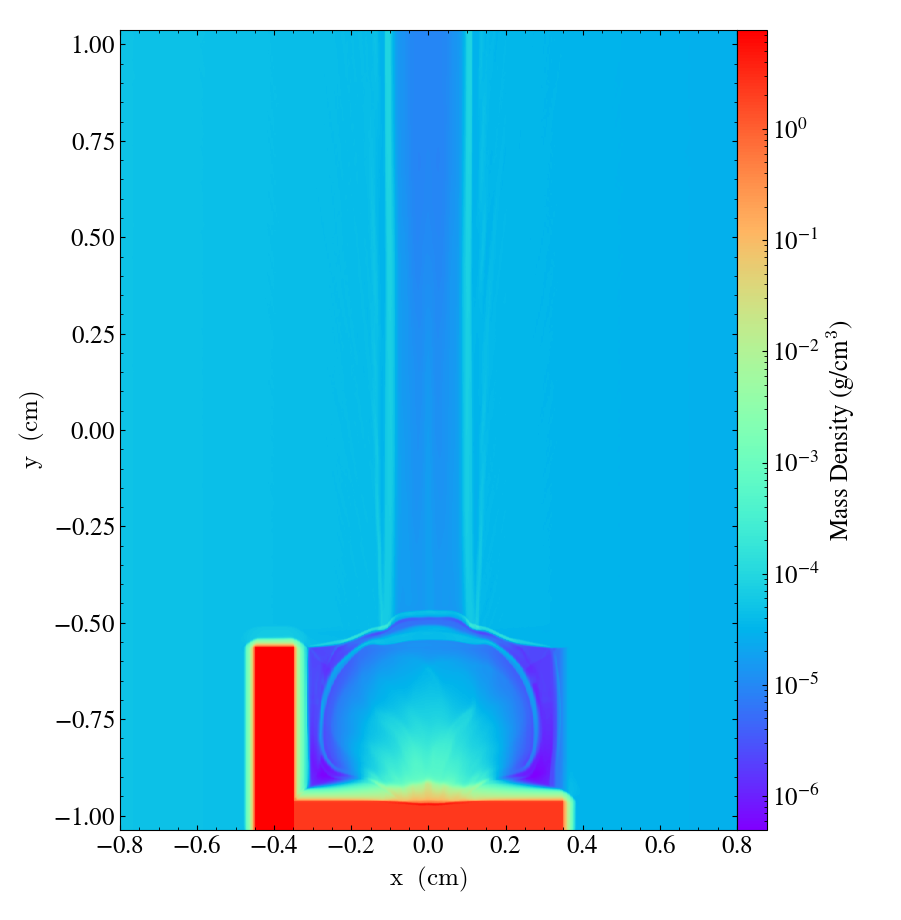

In [7]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","dens")).set_cmap("dens","rainbow")
# slc.set_font_size(30)
slc.set_colorbar_label("dens", r"Mass Density (g/cm$^3$)")
slc.save("../results/FLASH_plots/dens_slice.png")
slc.show()

yt : [INFO     ] 2024-11-11 18:06:12,681 xlim = -0.800000 0.800000
yt : [INFO     ] 2024-11-11 18:06:12,681 ylim = -0.075000 2.000000
yt : [INFO     ] 2024-11-11 18:06:12,683 xlim = -0.800000 0.800000
yt : [INFO     ] 2024-11-11 18:06:12,683 ylim = -0.075000 2.000000
yt : [INFO     ] 2024-11-11 18:06:12,683 Making a fixed resolution buffer of (('flash', 'magp')) 800 by 800
yt : [INFO     ] 2024-11-11 18:06:12,883 Saving plot ../results/FLASH_plots/magp_slice.png



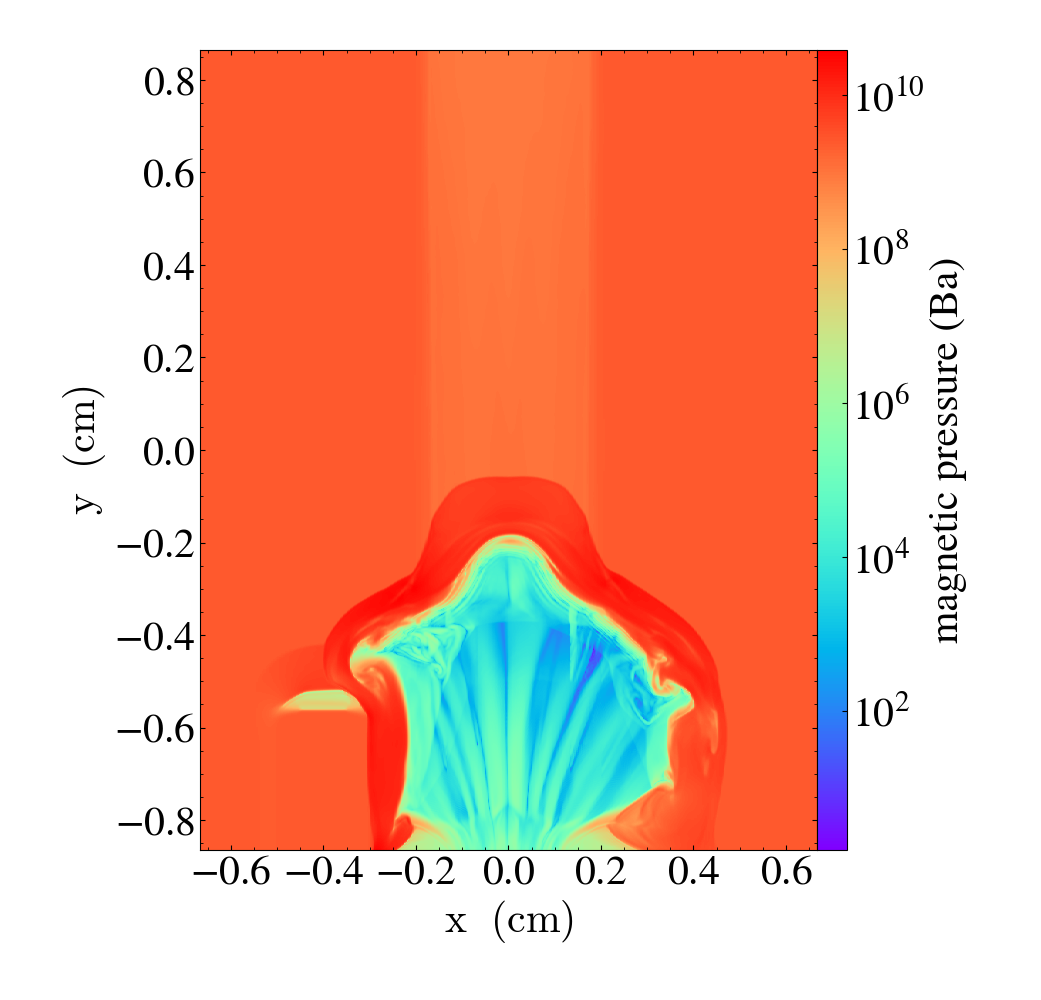

In [16]:
slc = yt.SlicePlot(ds, "z", ("flash","magp")).zoom(1.2).set_cmap("magp","rainbow")
# slc.set_log("magp", False)
slc.set_colorbar_label("magp", "magnetic pressure (Ba)")
slc.set_font_size(30)
slc.save("../results/FLASH_plots/magp_slice.png")
slc.show()

In [ ]:
slc = yt.SlicePlot(ds, "z", ("flash","tele")).zoom(1.2).set_cmap("tele","Reds")
kb = 8.617333262e-5
# slc.set_log("tele", False)
slc.frb["flash","tele"] *= kb
slc.set_colorbar_label("tele", "electron temp (eV)")
slc.set_font_size(30)
slc.save("../results/FLASH_plots/tele_slice.png")
slc.show()

yt : [INFO     ] 2025-02-25 18:21:14,525 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-02-25 18:21:14,525 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-02-25 18:21:14,527 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-02-25 18:21:14,527 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-02-25 18:21:14,527 Making a fixed resolution buffer of (('flash', 'tion')) 800 by 800


yt : [INFO     ] 2025-02-25 18:21:14,791 Saving plot ../results/FLASH_plots/tion_slice.png



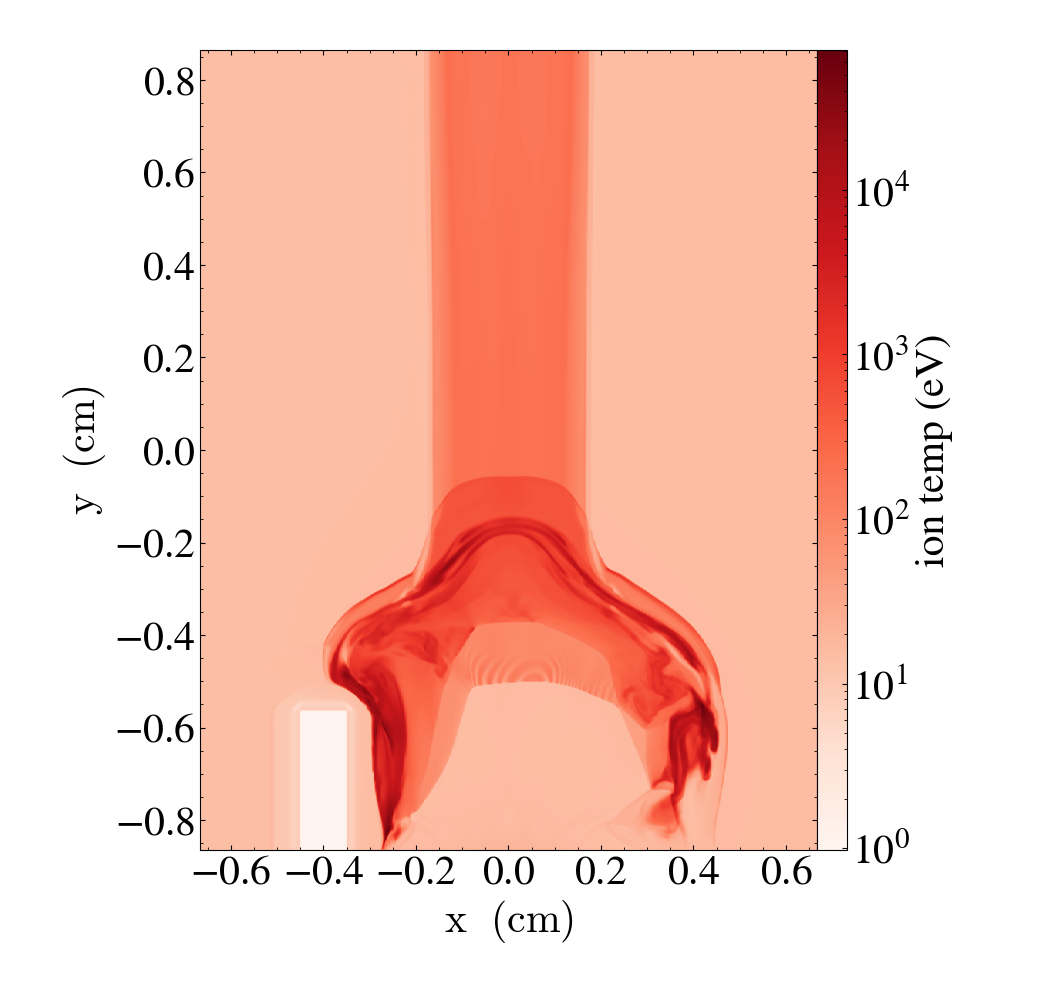


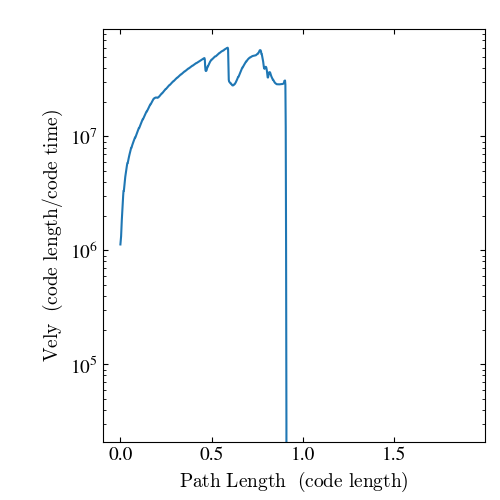

In [12]:
slc = yt.SlicePlot(ds, "z", ("flash","tion")).zoom(1.2).set_cmap("tion","Reds")
kb = 8.617333262e-5
slc.frb["flash","tion"] *= kb
slc.set_colorbar_label("tion", "ion temp (eV)")
slc.set_font_size(30)
slc.save("../results/FLASH_plots/tion_slice.png")
slc.show()

line = yt.LinePlot(ds,"vely",start_point=(0,0,0),end_point=(0,1.9,0),npoints=1000)
line.set_log("vely",True)
line.show()

yt : [INFO     ] 2025-01-17 17:25:17,182 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-01-17 17:25:17,183 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-01-17 17:25:17,184 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-01-17 17:25:17,184 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-01-17 17:25:17,185 Making a fixed resolution buffer of (('flash', 'vely')) 800 by 800
yt : [INFO     ] 2025-01-17 17:25:17,385 Saving plot ../results/FLASH_plots/vely_slice.png


6900127.060405759



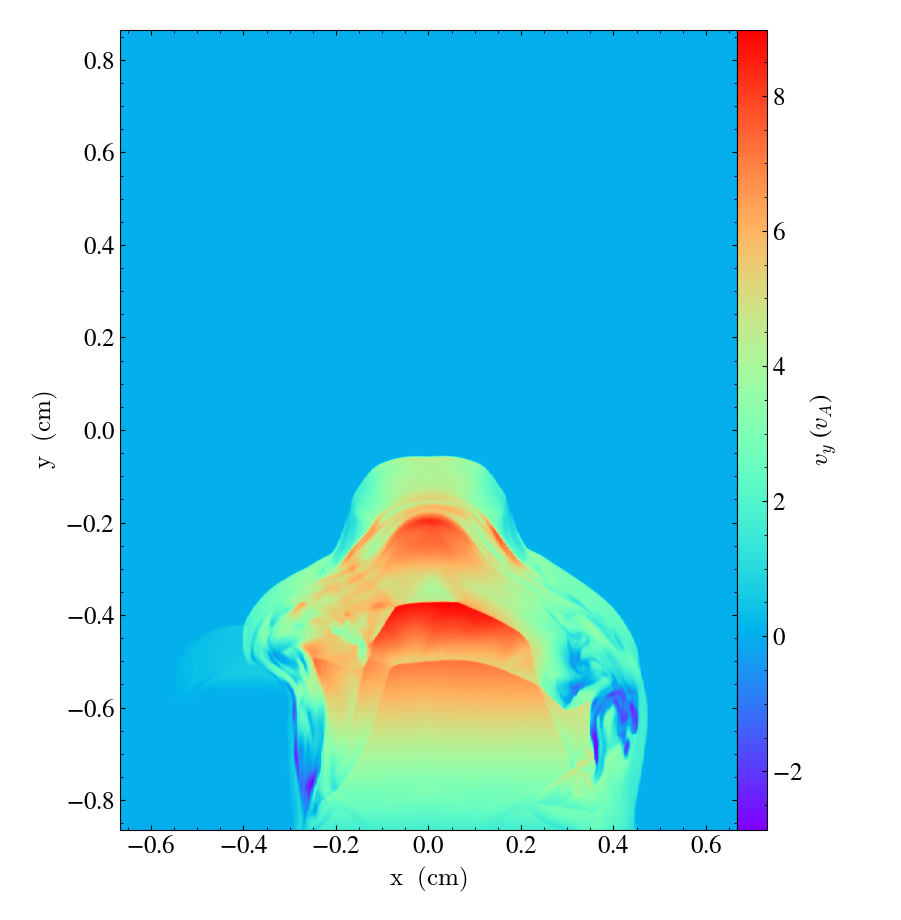

In [13]:
slc = yt.SlicePlot(ds, "z", ("flash","vely")).zoom(1.2).set_cmap("vely","rainbow")
slc.set_log("vely", False)
aluminum_molecular_weight = 26.98
proton_mass = 1.6726219e-24
ne_cgs = 5e18
Al_charge_state = 6
rho_0 = aluminum_molecular_weight*proton_mass*ne_cgs/Al_charge_state
v_alfven = 150000/np.sqrt(4*np.pi*rho_0)
print(v_alfven)
slc.frb["flash","vely"] = slc.frb["flash","vely"]/v_alfven
slc.set_colorbar_label("vely", "$v_y$ ($v_A$)")
slc.save("../results/FLASH_plots/vely_slice.png")
slc.show()

In [ ]:
plot_path = "/home/dschneidinger/cellar/DEREK2/MagShockZ_hdf5_chk_0005"
# plot_path = "/home/dschneidinger/cellar/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"

sys.path.append("../src")
ds = derive_fields(plot_path)

In [ ]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","edens")).zoom(1).set_cmap("edens","rainbow")
slc.set_font_size(30)
slc.set_colorbar_label("edens", r"Electron Density (cm$^{-3}$)")
slc.set_zlim("edens", 1e18, 8e21)
slc.save("../results/FLASH_plots/edens_slice_with_shield.png")
slc.show()

In [9]:
slc = yt.SlicePlot(ds, "z", ("flash, jx")).zoom(1).set_cmap("jx","rainbow")

YTFieldNotFound: Could not find field 'flash, jx' in MagShockZ_hdf5_chk_0028.

yt : [INFO     ] 2025-03-18 17:53:01,936 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-03-18 17:53:01,937 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-03-18 17:53:01,938 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-03-18 17:53:01,938 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-03-18 17:53:01,939 Making a fixed resolution buffer of (('flash', 'magx')) 800 by 800



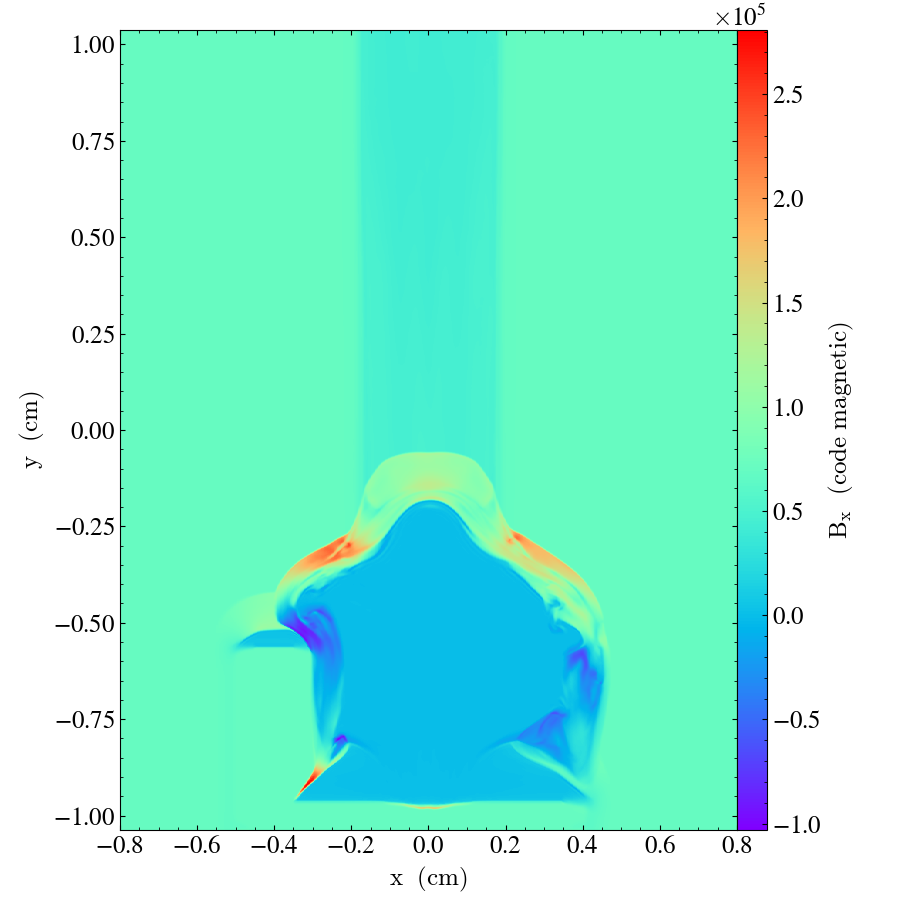

yt : [INFO     ] 2025-03-18 17:53:02,771 Saving plot ../results/FLASH_plots/magx_slice.png


['../results/FLASH_plots/magx_slice.png']

In [ ]:
slc = yt.SlicePlot(ds, "z", ("flash","magx")).zoom(1)
slc.set_cmap("magx","rainbow")
slc.set_log("magx", False)
slc.show()
slc.save("../results/FLASH_plots/magx_slice.png")

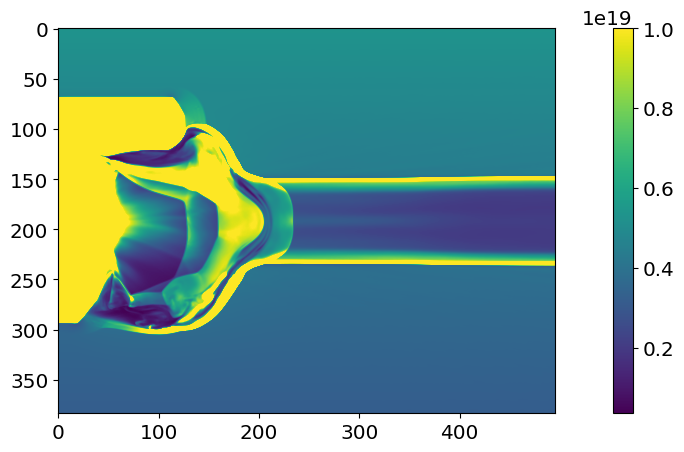

In [64]:
plt.imshow(all_data['edens'][:,:,(all_data['flash',"edens"].shape[2])//2],vmax = 1e19)
plt.colorbar()